# 3. MLP基礎（バッチ編）

## 概要
本演習ではChapter03で学習した、深層学習の基礎である多層パーセプトロン(バッチ処理)を穴埋め形式で実装します。<br>
予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。
演習問題文は<font color="Red">赤字</font>で表示されています。<br>
また、乱数設定により実行結果が異なるため、<font color="Red">コードを完成させたあと、必ずもう一度一番上のセルから順に最後まで実行して結果を確認してください。</font>

所要時間：5~8時間

### ライブラリのインポート
必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline
# 乱数シードを指定
np.random.seed(seed=0)

今回もデータセットとしてMNISTを使用し、`sklearn`の`train_test_split`を用いて訓練データ:テストデータ = 8:2 に分割します。

In [ ]:
if os.path.exists('mnist_784'):
    with open('mnist_784','rb') as f:
        mnist = pickle.load(f)
else:
    mnist = datasets.fetch_openml('mnist_784', as_frame=False)
    with open('mnist_784', 'wb') as f:
        pickle.dump(mnist, f)
# 画像とラベルを取得
X, T = mnist.data, mnist.target
# 訓練データとテストデータに分割
x_train, x_test, t_train, t_test = train_test_split(X, T, test_size=0.2)

# ラベルデータをint型にし、one-hot-vectorに変換します
t_train = np.eye(10)[t_train.astype("int")]
t_test = np.eye(10)[t_test.astype("int")]

データの準備はchapter2の後半と同様です。MNIST(数字の手書きデータ)を分類するモデルを学習させます。

## 最適化・バッチ正規化・ミニバッチ学習（スクラッチ）

#### データのサンプリング
画像・ラベルデータをランダムにいくつか取り出して可視化します。

画像は784要素の1次元ベクトルとしてXに格納されていますが、画像として表示するときは28x28の二次元にreshapeします。

#### データの並び替え

まずはデータをランダムに並び替えます。

常に先頭から表示しても良いですが、様々なデータを満遍なく確認したいときは、ランダム化するのが得策です。

ランダム化には```np.random.permutation```を使います。

引数に数値nを指定すると、0からn-1までの数字をランダムに並び替えた配列が生成されます。

In [ ]:
np.random.permutation(100)

array([49, 26, 11, 34, 10, 98, 37, 22, 90, 27, 50, 63, 47, 73, 82, 12, 33,
        1, 91,  6, 67, 64, 86, 20, 72, 25, 24,  3, 53, 32, 48, 16, 13, 52,
       92, 42,  9, 44, 78, 81, 89, 85, 45, 29, 68, 94, 36, 59, 62, 41, 61,
       66, 38, 40,  2, 69, 55, 99, 54, 83, 56,  7, 15, 88, 65, 57,  0, 51,
       46, 31, 80, 75,  8, 19, 23, 74,  4, 71, 93, 14, 21, 35, 39, 96, 97,
       18, 87, 43,  5, 70, 28, 76, 60, 17, 95, 77, 58, 30, 79, 84])

これでデータの「インデックス(番号)」をランダムに並び替えて、先頭から適当な数だけ取得することでランダムサンプリングと同等の動きができるようになります。

#### データのreshape

データは784次元のベクトルから、28×28の2次元型にreshapeする必要があります。

reshape前後でのデータの形状を見てみましょう。

In [ ]:
x_test[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,  89., 147., 147., 249., 230.,  59.,   2.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [ ]:
x_test[0].reshape(28,-1)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  89., 147., 147., 249., 230.,  59.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

array配列が入れ子状態のリストになっていることが分かりますね。

もし1次元の状態で```plt.imshow```を実行するとエラーが起きます。

TypeError: Invalid shape (784,) for image data

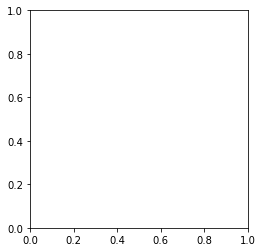

In [ ]:
plt.imshow(x_test[0])

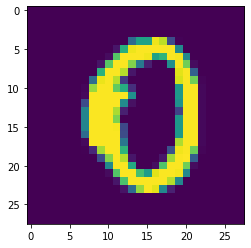

In [ ]:
plt.imshow(x_test[0].reshape(28,28))

あとは並び替えた配列```perm```を使用し、reshapeした画像をラベルと一緒に表示するようコーディングすればOKです。

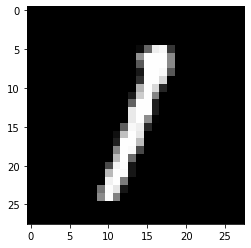

Label:  1


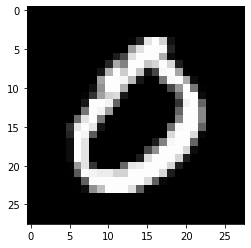

Label:  0


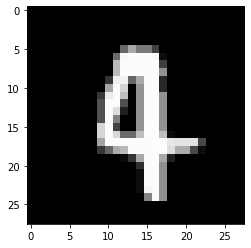

Label:  4


In [ ]:
# テストデータをランダムサンプリング
perm = np.random.permutation(len(x_test)) #len(x_test)=14000
# サンプル画像を表示する
plt.gray()
for i in perm[:3]:
    plt.imshow(x_test[perm[i]].reshape(28, 28)) #reshapeして2次元表示
    plt.show()
    print('Label: ', np.argmax(t_test[perm[i]])) #ラベルも一緒に表示

### Optimizerの実装

* <font color="Red">問1. 確率的勾配降下法を用いたOptimizerのクラス SGD を完成させてください。</font><br>
SGDの特徴として、データを変えることによって、損失関数自体を確率的に変えることができることが挙げられます。これによって、パラメータは同じであっても、勾配の向きを確率的に換えることができます。
この問題ではSGDのコードを回答してください。

In [ ]:
class SGD:

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= ### 問1 ###

#### 講義の復習

SGDでは、学習係数```lr```と勾配値```grad```を用いて、パラメータ```params```を更新することが目的です。

また、SGDによるパラメータの更新の式は以下の通りになります。

$$ \text{params} = \text{params} - lr * \text{grad} $$

これをコードで表現すると、以下の通りになります。


```
params = params - self.lr * grads
```

#### ```params.keys()```の意味

正しくSGDを実行するためには、前述の更新式を全ての```params```と対応する```grads```について実行する必要があります。

パラメータは1つとは限らないからです。

そこで、```params```を「パラメータの名前」(key)と「パラメータの値」(value)を持つ辞書として定義します。

(例)```params = {"w_1":0.25,"w_2":-0.32,"w_3":1.45}```とすると、パラメータについて「w_1=0.25,w_2=-0.32,w_3=1.45」という意味になる


In [ ]:
params = {"w_1":0.25,"w_2":-0.32,"w_3":1.45}
params["w_1"] #keyを指定するとvalueが取り出せる

0.25

こうすることで、```params.keys()```を用いて```params```が持つキー（```{"ID":0001}```の```ID```の部分）をリストで取得することができます。

そして、このリストの要素を１つずつ取得しているのが変数```key```となります。

この```key```に沿ってfor文を回せば、すべてのパラメータを更新できますね。

In [ ]:
params.keys() #keyのリストを取得

dict_keys(['w_1', 'w_2', 'w_3'])

これに加えて、```lr```の定義やパラメータを更新するメソッドなどを作成することで完成します。

* <font color="Red">問2. Adamクラス を完成させてください。</font><br>
Adamの特徴としてハイパーパラメータのバイアス補正(偏りの補正)が行われることが挙げられます。書籍『ゼロから作るDeepLearning』の配布コードは簡易版のため、バイアス補正を組み込んでいません。<br>
この問題ではバイアス補正を組み込んだ完成形のAdamコードについて回答してください。また、過去のE資格試験ではこちらの完成形のAdamコードが出題されています。

In [ ]:
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        
        for key in params.keys():
            self.m[key] = ###### 問2-1 ######
            self.v[key] = ###### 問2-2 ######
            m_unbias = ###### 問2-3 ######
            v_unbias = ###### 問2-4 ######
            params[key] -= self.lr * m_unbias / (np.sqrt(v_unbias) + 1e-7)

#### 講義の復習

まず、Adamの式について考えてみます。Adamの式は、講義スライドに載っているので合わせてご覧ください。

Adamではまず、```m```と```v```という２つの変数の更新を行います。

```m```の更新については、ハイパーパラメータ```beta1```と勾配値```grads```を用いると次のように表現することができます。

$$ m = \text{beta1} * m + (1 - \text{beta1}) * \text{grad} $$

上記と同じように、```v```の更新については、ハイパーパラメータ```beta2```と勾配値```grads```を用いると次のように表現することができます。

$$ v = \text{beta2} * v + (1 - \text{beta2}) * \text{grad}^2 $$

次に、```m```と```v```のバイアスの補正について説明します。

ここでは```m```のバイアス補正を```m-unbias```とします。```m```とハイパーパラメータ```iter```と```beta1```で表すと以下の通りになります。

$$ \text{m-unbias} = \frac{m}{1 - \text{beta1}^\text{iter}} $$

上記と同じようにして、```v```のバイアス補正を```v-unbias```とします。```v```とハイパーパラメータ```iter```と```beta2```で表すと以下の通りになります。

$$ \text{v-unbias} = \frac{v}{1 - \text{beta2}^\text{iter}} $$

最後に、パラメータ```params```の更新を行います。

これまで求めたものとハイパーパラメータ```lr```を用いて、パラメータの更新を行うと以下の通りになります。

$$ \text{params} = \text{params} - \text{lr} * \frac{\text{m-unbias}}{\sqrt{\text{v-unbias}} + ϵ} $$

なお、$ϵ$についてですが、$\text{v-unbias} = 0$のとき、分母が0になることでゼロ除算することを防ぐために加えます。$ϵ$は微小値（10^(-7)など）で構いません。

これらをコードに表現することができれば完成です。書いてみましょう。

In [ ]:
m = beta1 * m + (1 - beta1) * grads
v = beta2 * v + (1 - beta2) * grads**2
m_unbias = m / (1-beta1 ** iter)
v_unbias = v / (1-beta2 ** iter)
params -= lr * m_unbias / (np.sqrt(v_unbias) + ϵ)

#### keyの注意

Adamでも複数パラメータを更新するため、```key```を使ってfor文を回すことになります。

```params```の計算に使用する変数は```grad```と```params```と```self.m```、そして```self.v```です。

これらはキーごとに更新できるよう修正します。

なお、```lr```と```beta1```と```beta2```、そして```iter```はハイパーパラメータのため、keyが変わっても同じです。


なお、$ϵ$は$\text{v-unbias} = 0$のとき、分母が0になることでゼロ除算することを防ぐために加える微小値（10^(-7)など）です。

#### コスト関数

多クラス分類問題なので、クロスエントロピーをコスト関数として使用します。

In [ ]:
def cross_entropy_error(y, t):
    if y.ndim == 1: #変数の次元数が1の場合
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size: #教師データがOne-Hot表現の場合
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

また、ソフトマックス関数も定義しておきます。内容はchapter2で述べたので割愛します。

In [ ]:
def softmax(x):
    x = x.T
    x = x - np.max(x, axis=0)
    x = np.exp(x) / np.sum(np.exp(x), axis=0)
    return x.T

### バッチ正規化を用いないMLP

まずはバッチ正規化を入れない普通の三層ニューラルネットワークを実装します。問題にはなっていませんが、chapter02の復習も兼ねてコードを読み理解しておいてください。

In [ ]:
class mnistMultiLayerNet:
    """
    layer0: 784 次元の入力
    ↓ w1, b1 で線形結合
    ↓ relu で活性化
    layer1: 100 次元の隠れ層
    ↓ w2, b2 で線形結合
    ↓ relu で活性化
    layer2: 100 次元の隠れ層
    ↓ w3, b3 で線形結合
    ↓ relu で活性化
    layer3: 100 次元の隠れ層
    ↓ w4, b4 で線形結合
    ↓ relu で活性化
    layer4: 100 次元の隠れ層
    ↓ w5, b5 で線形結合
    layer5: 10 次元の出力層
    """
    def __init__(self):
        self.input_size = 784
        self.output_size = 10
        self.hidden_size_list = [100, 100, 100, 100]
        self.all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size] #全てのlayerの数
        self.hidden_layer_num = len(self.hidden_size_list) #隠れ層の数
        self.weight_decay_lambda =0
        self.params = {}
        self.layers = {}
        self.grads = {}

        # 重みとバイアスの初期化
        for idx in range(1, len(self.all_size_list)):
            self.params['w' + str(idx)] = np.random.randn(self.all_size_list[idx-1], self.all_size_list[idx]) * 0.085 
            #　str(idx)はパラメータをナンバリングするための文字列作成
            self.params['b' + str(idx)] = np.zeros(self.all_size_list[idx], dtype=float)

        
    def forward(self, x):
        relu = lambda x : np.maximum(0, x)  # 活性化関数として ReLU を使用
        self.layers['layer0'] = x
        for idx in range(1, len(self.all_size_list) - 1):
            w = self.params['w' + str(idx)]
            b = self.params['b' + str(idx)]
            x = self.layers['layer' + str(idx - 1)]
            self.layers['layer' + str(idx)] = relu(np.dot(x, w) + b)
        idx = len(self.all_size_list) - 1
        w = self.params['w' + str(idx)]
        b = self.params['b' + str(idx)]
        x = self.layers['layer' + str(idx - 1)]
        self.layers['layer' + str(idx)] = softmax(np.dot(x, w) + b)
        
        return self.layers['layer' + str(idx)]
        

    def loss(self, y, t):
        return cross_entropy_error(y, t)
    
    def backward(self, t, y):
        delta = (y - t) / t.shape[0]
        self.grads['b5'] = np.sum(delta, axis=0)
        self.grads['w5'] = np.dot(self.layers['layer4'].transpose(), delta)
        # 誤差逆伝播
        for idx in range(4, 0, -1):
            delta = np.dot(delta, self.params['w' + str(idx + 1)].transpose())
            delta = delta *  (self.layers['layer' + str(idx)] > 0)
            self.grads['b' + str(idx)] = np.sum(delta, axis=0)
            self.grads['w' + str(idx)] = np.dot(self.layers['layer'+str(idx - 1)].transpose(), delta)
        return self.grads


実験として、初期設定における```all_size_list```と```hidden_layer_num```を見てみましょう。

In [ ]:
input_size = 784
output_size = 10
hidden_size_list = [100, 100, 100, 100]
all_size_list = [input_size] + hidden_size_list + [output_size] #パラメータの総数
hidden_layer_num = len(hidden_size_list)
print(all_size_list)
print(len(hidden_size_list))

[784, 100, 100, 100, 100, 10]
4


### バッチ正規化を用いたMLP
* <font color="Red">問3. バッチ正規化を用いたMLPクラスを完成させる</font><br>
    * <font color="Red">問3-1. 【forward関数】ミニバッチの平均を算出する処理を記述してください。</font><br>
    * <font color="Red">問3-2. 【forward関数】ミニバッチの分散を算出する処理を記述してください。</font><br>
    * <font color="Red">問3-3. 【forward関数】移動平均により全体の平均を求める処理を記述してください。</font><br>
    * <font color="Red">問3-4. 【forward関数】移動平均により全体の分散を求める処理を記述してください。</font><br>
    * <font color="Red">問3-5,3-6. 【forward関数】テスト時における全体の平均と分散を使った正規化する処理を記述してください。</font><br>
    * <font color="Red">問3-7,3-8. 【backward関数】β, γの勾配を算出する処理を記述してください。</font><br>

各層について、重みを掛けて足し合わせた後バッチ正規化を行う。

  バッチ正規化の順伝播は以下の式に従って実装します。
  
  - （訓練時のみ）まずは計算しているミニバッチについて、平均と分散を求めます。各次元について、全データを通じた平均・分散を計算するため、平均・分散を計算する軸にご注意ください。

  - （訓練時のみ）テスト時に使用するために、訓練データ全体での平均を推定します。モーメンタム $m$ を用いて今までの平均 $\mu_{old} $ を計算しているミニバッチの平均 $\mu$ の方向に移動させ、新しい平均$\mu_{new} $を求めます。
  $$
  \mu_{new} = m \mu_{old} + ( 1 - m)\mu\tag{1}
  $$

  - （訓練時のみ）同様に今までの分散 $\sigma_{old} ^ 2$ を計算しているミニバッチの平均 $\sigma^2$の方向に移動させ、 新しい分散$\sigma_{new}^2$ を求めます。
  $$
  \sigma_{new}^2 = m \sigma_{old}^2 + ( 1 - m)\sigma^2\tag{2}
  $$

  - 求めた平均 $\mu$ と分散 $\sigma^2$ を用いて、入力 $x$ を正規化した値 $x_n$ を求めます。分散$\sigma^2$から標準偏差 $\sigma$ を求めるときに、アンダーフローを避けるために 10e-7 ($10 \times 10 ^ {-7}$) を足してから平方根を取っています。
  テスト時には、移動平均により推定した訓練データ全体での平均・分散を使用します。
  $$
  \sigma = \sqrt{\sigma ^ 2 + 10 \times 10 ^ {-7}}\tag{3}
  $$
  $$
  x_n = (x - \mu) / \sigma\tag{4}
  $$

   - 正規化した値 $x_n$に対して $\gamma$ を用いて変倍し、$\beta$ を用いて移動を行い、活性化関数に渡す出力 $y$ を求めます。
   $$
   y = \gamma x_n + \beta\tag{5}
   $$
 
   バッチ正規化の誤差逆伝播は以下の式に従って実装します。
   
   - 直前まで逆伝播してきた$1, 2, \dots , N$ 番目(Nはバッチサイズ)の出力データ$y_k$による勾配 $\frac{\partial L}{\partial y_k}$を用いて $\gamma$ と$\beta$による勾配を計算します。 $x_{nk}$ はミニバッチの中のk番目の入力データを正規化した後の値を表します。
   $$
   \begin{eqnarray} 
   \frac{\partial L}{\partial \gamma} & = & \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} \frac{\partial y_k}{\partial \gamma} = \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} x_{nk}\tag{6}\\
\frac{\partial L}{\partial \beta} & = & \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} \frac{\partial y_k}{\partial \beta} =  \sum_{k=1}^{N} \frac{\partial L}{\partial y_k}\tag{7}
\end{eqnarray}
   $$
   
   - $1, 2, \dots , N$ 番目の入力データ$x_k$による勾配 $\frac{\partial L}{\partial x_k}$を計算します（コードでは高速化のため少々異なった計算をしています）。
   
   $$
  \begin{equation} 
  \frac{\partial L}{\partial x_k} 
  = \frac{\gamma}{\sigma} \Bigg[ \frac{\partial L}{\partial y_k} 
  - \frac{1}{N} \bigg[ \frac{\partial L}{\partial \beta} + x_{nk} \frac{\partial L}{\partial \gamma} \bigg] \Bigg] 
  \end{equation}
  $$

In [ ]:
class mnistMultiLayerBatchNet:
    """
    layer0: 784 次元の入力
    ↓ w1, b1 で線形結合
    ↓バッチ正規化 gamma1倍しbeta1だけずらす
    ↓ relu で活性化
    layer1: 100 次元の隠れ層
    ↓ w2, b2 で線形結合
    ↓バッチ正規化 gamma2倍しbeta2だけずらす
    ↓ relu で活性化
    layer2: 100 次元の隠れ層
    ↓ w3, b3 で線形結合
    ↓バッチ正規化 gamma3倍しbeta3だけずらす
    ↓ relu で活性化
    layer3: 100 次元の隠れ層
    ↓ w4, b4 で線形結合
    ↓バッチ正規化 gamma4倍しbeta4だけずらす
    ↓ relu で活性化
    layer4: 100 次元の隠れ層
    ↓ w5, b5 で線形結合
    layer5: 10 次元の出力層
    """
    def __init__(self):
        self.input_size = 784
        self.output_size = 10
        self.hidden_size_list = [100, 100, 100, 100]
        self.all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        self.hidden_layer_num = len(self.hidden_size_list)
        self.weight_decay_lambda =0
        self.params = {}
        self.layers = {}
        self.grads = {}
        self.norms = {}
        self.momentum = 0.9

        # パラメータの初期化
        for idx in range(1, len(self.all_size_list)):
            # 線形結合層のパラメータ
            self.params['w' + str(idx)] = np.random.randn(self.all_size_list[idx-1], self.all_size_list[idx]) * 0.085
            self.params['b' + str(idx)] = np.zeros(self.all_size_list[idx], dtype=float)
            
            # バッチ正規化でシフトさせるときに用いるγとβを更新するパラメータとし初期化
            # mu と sigma は実行時の平均と分散
            if idx != len(self.all_size_list) - 1:
                self.params['gamma' + str(idx)] = np.ones(self.all_size_list[idx])
                self.params['beta' + str(idx)] = np.zeros(self.all_size_list[idx])
                self.norms['mu' + str(idx)] = None
                self.norms['var' + str(idx)] = None
        
    def forward(self, x, train_flg=False):
        relu = lambda x : np.maximum(0, x)  # 活性化関数として ReLU を使用
        self.layers['layer0'] = x
        for idx in range(1, len(self.all_size_list) - 1):
            # 線形結合層
            w = self.params['w' + str(idx)]
            b = self.params['b' + str(idx)]
            x = self.layers['layer' + str(idx - 1)]
            x = np.dot(x, w) + b
            
            # バッチ正規化
            # 平均と分散の初期化
            if self.norms['mu' + str(idx)] is None:
                N, D = x.shape
                self.norms['mu' + str(idx)] = np.zeros(D)
                self.norms['var' + str(idx)] = np.zeros(D)
            if train_flg:
                mu = ###### 問3-1 ######
                xc = x - mu                   # 今回のミニバッチの平均との差分
                var = ###### 問3-2 ###### 
                std = np.sqrt(var + 10e-7)    # 今回のミニバッチの標準偏差
                xn = xc / std                 # 正規化

                # 全体の平均と分散を移動平均により求める(1),(2)
                self.norms['mu' + str(idx)] = ###### 問3-3 ######
                self.norms['var' + str(idx)] = ###### 問3-4 ######
                
                # 誤差逆伝播で使う中間データ
                self.norms['xc' + str(idx)] = xc
                self.norms['xn' + str(idx)] = xn
                self.norms['std' + str(idx)] = std
                self.norms['size' + str(idx)] = x.shape[0]
            else:
                # テスト時は全体の平均と分散を使って正規化する(3),(4)
                xc = ###### 問3-5 ######
                xn = ###### 問3-6 ######
                
            # γ,βを用いてシフトさせる(5)
            shifted = self.params['gamma' + str(idx)] * xn + self.params['beta' + str(idx)]
            
            # relu を使って活性化
            self.layers['layer' + str(idx)] = relu(shifted)

        # 出力層
        idx = len(self.all_size_list) - 1
        w = self.params['w' + str(idx)]
        b = self.params['b' + str(idx)]
        x = self.layers['layer' + str(idx - 1)]
        self.layers['layer' + str(idx)] = softmax(np.dot(x, w) + b)
        
        return self.layers['layer' + str(idx)]
        

    def loss(self, y, t):
        return cross_entropy_error(y, t)
    
    def backward(self, t, y):
        # 出力層における誤差の勾配（クロスエントロピー関数の勾配）
        delta = (y - t) / t.shape[0]
        
        # 出力層手前の線形結合層における勾配の逆伝播
        self.grads['b5'] = np.sum(delta, axis=0)
        self.grads['w5'] = np.dot(self.layers['layer4'].transpose(), delta)
        
        # 誤差逆伝播
        for idx in range(4, 0, -1):
            delta = np.dot(delta, self.params['w' + str(idx + 1)].transpose())
            
            # relu の微分
            delta = delta *  (self.layers['layer' + str(idx)] > 0)
            
            # バッチ正規化における勾配の逆伝播(6),(7)
            self.grads['beta' + str(idx)] = ###### 問3-7 ######
            self.grads['gamma' + str(idx)] = ###### 問3-8 ######
            dxn = self.params['gamma' + str(idx)] * delta
            dxc = dxn / self.norms['std' + str(idx)]
            dstd = -np.sum((dxn * self.norms['xc' + str(idx)]) / (self.norms['std' + str(idx)] * self.norms['std' + str(idx)]), axis=0)
            dvar = 0.5 * dstd / self.norms['std' + str(idx)]
            dxc += (2.0 / self.norms['size' + str(idx)]) * self.norms['xc' + str(idx)] * dvar
            dmu = np.sum(dxc, axis=0)
            delta = dxc - dmu / self.norms['size' + str(idx)]
            
            # 線形結合層における勾配の逆伝播
            self.grads['b' + str(idx)] = np.sum(delta, axis=0)
            self.grads['w' + str(idx)] = np.dot(self.layers['layer'+str(idx - 1)].transpose(), delta)
            
        return self.grads


#### <font color="Red">問3-1/3-2　ヒント</font>

まず、ミニバッチの平均と分散について考えます。

ミニバッチは、```x```が該当します。```x```は、入力データに重みを掛けて、バイアスを足し合わせたものとなっております。

ミニバッチの平均値についてですが、```変数名.mean()```をいうpythonの関数を用いて取得することができます。

また、バッチごとに計算するという操作は、行列で言うと列ごとに計算する操作に該当します。これで```axis```を決められます。

次に分散についてですが、次のように求められます。

<ol>
    <li>ミニバッチの各値と平均の差を求める</li>
    <li>1で求めた値をそれぞれ2乗し、この値の平均をもとめる</li>
</ol>

問3-1で求めた平均値を```xu```、(1)の結果を```xc```とすると```xc = x - mu ```と表すことができます。

そして、(2)の結果を```var```とすると、2乗と平均について1行でコーディングできるはずです。

なお、```var```についても、バッチごと（列ごと、縦ごと）に見ていくため、```axis```は問3-1と同様となります。

#### <font color="Red">問3-3/3-4　ヒント</font>

次に、移動平均による全体の平均・分散について考えます。

移動平均による全体の平均については、解説文の式（１）、分散の平均については、解説文の式（２）に書かれております。

まず、平均については次の通りに求めることができます。

$$ \mu_{new} = m \mu_{old} + ( 1 - m)\mu $$

ここで、```m```とは、```self.momentum```、```μ_old```は```self.norms['mu' + str(idx)]```、```μ```は```mu```を表します。

次に、分散については次の通りに求めることができます。

$$ \sigma_{new}^2 = m \sigma_{old}^2 + ( 1 - m)\sigma^2 $$

ここで、```m```とは、```self.momentum```、```σ_old```は```self.norms['var' + str(idx)]```、```σ```は```var```を表します。

使用する変数と計算方法が分かれば、コーディングできるはずです。

#### <font color="Red">問3-5/3-6　ヒント</font>

次に、全体の平均と分散を使って正規化を表現する部分です。

正規化については、解説文の式（３）、分散の平均については、解説文の式（４）から、以下のように求めることができます。

$$ x_n = (x - \mu) / \sigma\tag{a} $$

なお、```σ```については、次の通りです。

$$ \sigma = \sqrt{\sigma ^ 2 + 10 \times 10 ^ {-7}}\tag{b} $$

この(a)の分子部分が問3-5で問われている「全体の平均」となります。

```x```については```x```、```mu```については、```self.norms['mu' + str(idx)]```と表すことができます。

```x - mu```を```xc```で表すことにして、コーディングしてみましょう。これが問3-5となります。

次に、(a)の分母部分、つまり(b)について考えます。(a)の分母・分子を完全にコードで表現したものが問3-6になります。

コード上では、```σ^2```は```self.norms['var' + str(idx)]```、```10 * 10^(-7)```は```10e-6```または```10*10e-7```と表せます。

また、√は```np.sqrt()```で表現できます。従って、分散に微小値を加えて平方根を取ったものとしてコーディングできますね。

この正規化の結果```xn```が問3-6となります。

#### <font color="Red">問3-7/3-8　ヒント</font>

最後に、逆伝播に使う$\beta$と$\gamma$の勾配を算出する処理です。

解説文の式(6)(7)をもとに求めて行きます。

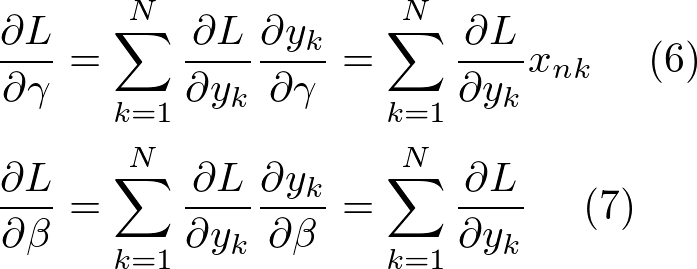

まずは、問3-7の$\frac{\partial L}{\partial \beta}$についてです。式では(7)にあたります。

勾配 $\frac{\partial L}{\partial y_k}$は、コードで表現すると```delta```になります。

```delta```は、ReLUの出力を微分したものです。コード上では入力データと同じ形状のベクトルになります。

(7)より、$\frac{\partial L}{\partial \beta}$は```delta```の合計によって求めることができますね。

このとき、軸```axis```に注意して合計しましょう。

そして、問3-8の$\frac{\partial L}{\partial \gamma}$についてです。式では(6)にあたります。

ここでは勾配 $\frac{\partial L}{\partial y_k}$に加えて$x_{nk}$を使用します。

$x_{nk}$は、コードで```self.norms['xn' + str(idx)]```と表すことができます。

これは問3-5の直前のコードで定義されています。

$\frac{\partial L}{\partial \gamma}$は、勾配 $\frac{\partial L}{\partial y_k}$と$x_{nk}$との積の総和を表します。

これも軸```axis```に注意して合計しましょう。

### ミニバッチを用いた学習

ミニバッチを用いた学習を行います。

* <font color="Red">問4. ランダムサンプリングのためにインデックスをランダムに読み込む処理を記述しましょう。</font>
* <font color="Red">問5. バッチサイズごとに入力と教師データを読み込む処理を記述しましょう。</font>

ヒント: numpy.random.permutation を用いることで、データのインデックスをシャッフルした配列を用意することで、シャッフルインデックス配列permに対して、前からバッチサイズずつインデックスを切り出せばミニバッチの抽出が行えます。

また、学習用のコードは実行に時間がかかります。完了するまで5~10分ほどを要しますのでご注意ください。


#### 問4

これは```np.random.permutation```を使用します。この章の冒頭でやりましたね。

学習データのインデックスをランダムに読み込みたいときに、どのくらいの長さの配列を作ればよいか考えてみましょう。

#### 問5

問題5では、バッチサイズごとに入力と教師データを読み込む処理を実装するために、配列の範囲を指定します。

#### np.arange()による配列

```np.arange(0, len(perm), batch_size)```は、0をスタートとして順番に```batch_size```を足していき、```len(perm)```を超えない範囲まで連続した数値を要素として持つ配列を生成します。

コードで表現すると```[0,batch_size,batch_size*2,....,batch_size*n(batch_size*n <= len(perm))]```となります。

実験として、len(perm)を1000、batch_sizeを100としてみましょう。

In [ ]:
len_perm = 1000
batch_size = 100
np.arange(0, len_perm, batch_size)

array([  0, 100, 200, 300, 400, 500, 600, 700, 800, 900])

このようにキリの良い配列を作ることで、バッチが切り替わる部分のインデックスだけをまとめた配列を作成できます。

#### インデックスの始点と終点

インデックスの始点と終点を考えます。

カギとなる変数は問題の通り```idx```となります。```idx```とは、```np.arange(0, len(perm), batch_size)```によって作成された配列の要素です。

つまり、ミニバッチの開始となるキリの良い番号のことですね。これを始点にしましょう。（もちろん他のやり方もあります）

次に終点ですが、batch_sizeごとにデータを読み込むため、```idx + batch_size```となります。

上記の例だと、データ数(len_perm)が1000、バッチサイズ(batch_size)が100となります。

このとき、各バッチに対応するインデックスは以下のようになります。

- 第1バッチ：idx = 0 ～ 99 (リストの番号が0を含むため)

- 第2バッチ：idx = 100 ～ 199

- 第3バッチ：idx = 200 ～ 299......

リストの書き方としては[0,100],[100,200],[200,300]...となります。

In [ ]:
len_perm = 1000
batch_size = 100
for idx in np.arange(0, len_perm, batch_size):
    print(idx,idx+batch_size)

0 100
100 200
200 300
300 400
400 500
500 600
600 700
700 800
800 900
900 1000


従って、```x_train```と```t_train```に対してこれらの範囲指定をコーディングしてやればOKです。

このとき、問題4でランダムに並び替えた配列```perm```を使用する点に注意しましょう。

In [ ]:
bn = mnistMultiLayerBatchNet()
nobn = mnistMultiLayerNet()
adambn = mnistMultiLayerBatchNet()
adamnobn = mnistMultiLayerNet()

bn_acc_list = []
nobn_acc_list = []
adambn_acc_list = []
adamnobn_acc_list = []

sgd = SGD(lr = 0.01)
adam = Adam(lr=0.01)

sgd_norm = SGD(lr = 0.01)
adam_norm = Adam(lr=0.01)

# ミニバッチアルゴリズム
batch_size = 128

In [ ]:
for epoch in range(20):
    # ランダムにミニバッチを読み込むために、インデックスをランダムに並び替える
    perm = ###### 問4 ######
    # batch_size ごとにデータを読み込んで学習させる
    for idx in np.arange(0, len(perm), batch_size):
        x = ###### 問5-1 ######
        t = ###### 問5-2 ######
        
        y = bn.forward(x, train_flg=True)
        grads = bn.backward(t, y)
        sgd_norm.update(bn.params,grads)
        
        y = adambn.forward(x, train_flg=True)
        grads = adambn.backward(t, y)
        adam_norm.update(adambn.params,grads)
        
        y = nobn.forward(x)
        grads = nobn.backward(t,y)
        sgd.update(nobn.params, grads)
        
        y = adamnobn.forward(x)
        grads = adamnobn.backward(t, y)
        adam.update(adamnobn.params,grads)

    y_test = bn.forward(x_test)
    bn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = nobn.forward(x_test)
    nobn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = adambn.forward(x_test)
    adambn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = adamnobn.forward(x_test)
    adamnobn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())

    print(f'EPOCH {epoch + 1} | NoBatch ACCURACY (SGD) {nobn_acc_list[-1]:.2%} | Batch ACCURACY (SGD){bn_acc_list[-1]:.2%} | NoBatch ACCURACY (Adam){adamnobn_acc_list[-1]:.2%} | Batch ACCURACY (Adam) {adambn_acc_list[-1]:.2%}')

### 学習結果
学習結果を可視化してみます。まずはSGDを使った学習についてのみ比較を行います。結果のグラフが以下のグラフと一致していれば学習は成功しています。

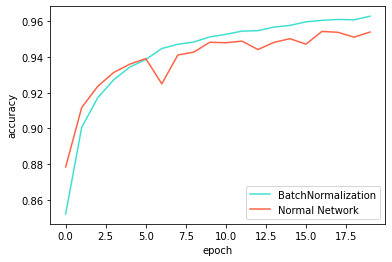
学習結果からわかる通り、バッチ正規化を加えることでテスト精度が高い水準で安定させることが可能となります。

In [ ]:
x = range(20)
plt.plot(x, bn_acc_list, color='turquoise')
plt.plot(x, nobn_acc_list, color='tomato')

plt.legend(['BatchNormalization', 'Normal Network'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

次にAdamで学習した場合も含めてプロットしてみましょう。結果のグラフの特徴が以下と一致していれば学習成功です。<br>
・Adamで学習すると、SGDよりも学習が進みやすく、高い精度が実現できている。<br>
・バッチ正規化を加えないネットワークでは過学習により途中からテスト精度が急に低下している。<br>
バッチ正規化を加えることで正則化の役割も可能となっていることが読み取れます。

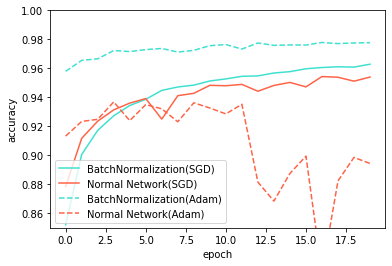

In [ ]:
x = range(20)
plt.plot(x, bn_acc_list, color='turquoise', linestyle = '-')
plt.plot(x, nobn_acc_list, color='tomato', linestyle='-')
plt.plot(x, adambn_acc_list, color='turquoise', linestyle = '--')
plt.plot(x, adamnobn_acc_list, color='tomato', linestyle='--')

plt.ylim((0.85, 1))

plt.legend(['BatchNormalization(SGD)', 'Normal Network(SGD)', 'BatchNormalization(Adam)', 'Normal Network(Adam)'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()